In [1]:
import numpy as np
import scipy
from scipy.ndimage import gaussian_filter1d
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
%matplotlib inline
import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp
import database
db = database.db

import change_point_analysis as cpa
import change_point_plot as cpp

In [2]:
data_dir_full=db.query('owner=="roman"')['data_dir_full'][0]
data_dir_full
db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False).head(10)

data_dir_full  \
animal_name                                                        
e13_26m1    0  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_26...   
e15_13f1    0  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
            1  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
            2  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
            3  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
e13_26m1    1  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_26...   
e13_16f1    7  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_16...   
e13_26m1    2  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_26...   
e16_3m2     3  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m...   
e16_3m1     0  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m...   

                     sess_name animal_name.1        date  \
animal_name                                                
e13_26m1    0  e13_26m1_210913      e13_26m1  2021-09-13   
e15_13f1    0  e15_13f1_220117      e15_13f1  2022-01-17   
            1  e15_13f1_220118      e15_13f1  2022-01-18   
            2  e15_13f1_220119      e15_13f1  2022-01-19   
            3  e15_13f1_220120      e15_13f1  2022-01-20   
e13_26m1    1  e13_26m1_211019      e13_26m1  2021-10-19   
e13_16f1    7  e13_16f1_210328      e13_16f1  2021-03-28   
e13_26m1    2  e13_26m1_211116      e13_26m1  2021-11-16   
e16_3m2     3   e16_3m2_211213       e16_3m2  2021-12-13   
e16_3m1     0   e16_3m1_210111       e16_3m1  2021-01-11   

                                    behavior  performance  ntrials  \
animal_name                                                          
e13_26m1    0                    alternation     0.956522       69   
e15_13f1    0                    alternation     0.617647       34   
            1   ['alternation' 'linearMaze']     0.740741       27   
            2  ['alternation' 'alternation']     0.721311       61   
            3   ['alternation' 'linearMaze']     0.800000       45   
e13_26m1    1  ['alternation' 'alternation']     0.730769       78   
e13_16f1    7                    alternation     0.850000       20   
e13_26m1    2   ['alternation' 'linearMaze']     0.850000       20   
e16_3m2     3  ['alternation' 'alternation']     0.703704       54   
e16_3m1     0                    alternation     0.882353       17   

               ngoodtrials  n_neurons  n_pyr_putative  owner   data_root  
animal_name                                                               
e13_26m1    0           69        482             422  roman  roman_data  
e15_13f1    0           34        376             333  roman  roman_data  
            1           27        363             318  roman  roman_data  
            2           61        343             288  roman  roman_data  
            3           45        303             248  roman  roman_data  
e13_26m1    1           78        271             228  roman  roman_data  
e13_16f1    7           20        211             174  roman  roman_data  
e13_26m1    2           20        209             173  roman  roman_data  
e16_3m2     3           54        207             163  roman  roman_data  
e16_3m1     0           17        203             162  roman  roman_data

In [62]:
db.query('owner=="roman"')[['behavior','sess_name']]

behavior        sess_name
animal_name                                                  
e13_16f1    0                    alternation  e13_16f1_210302
            1                    alternation  e13_16f1_210312
            2                    alternation  e13_16f1_210314
            3                    alternation  e13_16f1_210315
            4                    alternation  e13_16f1_210317
...                                      ...              ...
e16_3m1     3                    alternation   e16_3m1_210203
e16_3m2     0                    alternation   e16_3m2_211210
            1   ['alternation' 'linearMaze']   e16_3m2_211211
            2   ['alternation' 'linearMaze']   e16_3m2_211212
            3  ['alternation' 'alternation']   e16_3m2_211213

[67 rows x 2 columns]

In [3]:
# data_dir_full = '/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/'
# data_dir_full = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][0]
data_dir_full = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][0]

In [63]:
data_dir_full = '/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211211/'

In [64]:
# load data
mat_to_return=prep.load_stuff(data_dir_full)
# sessionPulses=mat_to_return['sessionPulses']
# filtered = mat_to_return['filtered']
behavior=mat_to_return['behavior']
# ripples = mat_to_return['ripples']


prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
spk_beh_df=prep_res['spk_beh_df']
_,spk_beh_df=dpp.group_into_trialtype(spk_beh_df)
cell_cols_d = prep_res['cell_cols_d']
beh_df = prep_res['beh_df'].as_dataframe()
beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)
spike_trains = prep_res['spike_trains']

In [4]:
import place_field_analysis as pf
reload(pf)
reload(pa)

<module 'place_cell_analysis' from '/mnt/home/szheng/projects/util_code/place_cell_analysis.py'>

In [65]:
cell_cols = cell_cols_d['pyr']
nbins = 100
spk_beh_df,lin_bins = dpp.add_lin_binned(spk_beh_df,nbins=nbins)
fr_map_d,count_d,occu_d = pf.ratemap_from_spk_beh_df_alltrialtype(spk_beh_df,cell_cols,speed_thresh=1,nbins=nbins,smth_in_bin=2.5)



In [66]:
reload(pa)
cell_cols = cell_cols_d['pyr']
fr_map_dict=pa.get_fr_map_trial(spk_beh_df,cell_cols,trialtype_key='trial_type',speed_thresh=1.,order=['smooth','divide'])
fr_map_trial_d = {k:val[0] for k,val in fr_map_dict.items()}
fr_map_trial_df=pf.fr_map_trial_to_df(fr_map_trial_d[0,0],cell_cols)


cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe


In [16]:
spk_beh_df.loc[spk_beh_df['trial_type']==(1,0)]['lin_binned'].unique()

array([79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 96,
       97, 98, 99, 95, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 65,
       64, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 51, 50, 49, 48, 47, 46,
       45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29,
       28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 66, 63, 52, 17, 16, 15,
       14])

In [69]:
data_dir_full

'/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211211/'

<AxesSubplot:xlabel='Time (s)'>

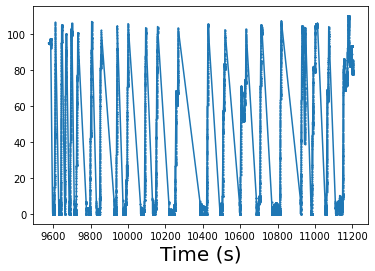

In [77]:
%matplotlib inline
spk_beh_df.loc[spk_beh_df['trial_type']==(1,1)]['lin'].plot(marker='o',markersize=1)

<AxesSubplot:xlabel='Time (s)'>

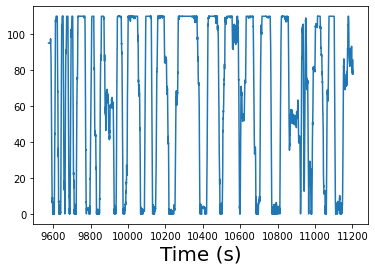

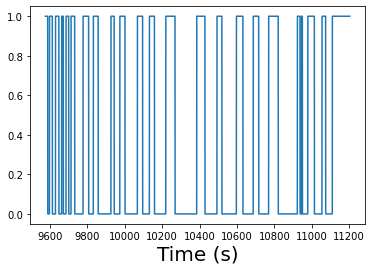

In [70]:
spk_beh_df.loc[spk_beh_df['task_index']==1]['lin'].plot()
plt.figure()
spk_beh_df.loc[spk_beh_df['task_index']==1]['direction'].plot()

In [58]:
spk_beh_df.loc[spk_beh_df['task_index']==1]['direction'].head(700)

Time (s)
16402.539567    1
16402.579567    1
16402.619567    1
16402.659567    1
16402.699567    1
               ..
16430.341167    0
16430.381167    0
16430.421167    0
16430.461167    0
16430.501167    0
Name: direction, Length: 700, dtype: uint8

<AxesSubplot:xlabel='Time (s)'>

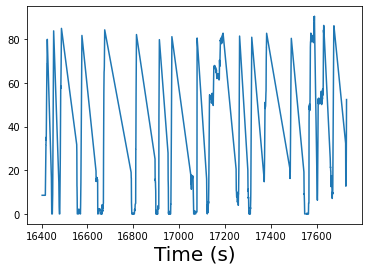

In [47]:
spk_beh_df.loc[spk_beh_df['task_index']==1]['lin'].loc[spk_beh_df.loc[spk_beh_df['task_index']==1]['direction']==1].plot()




In [45]:
behavior['trials']['trial_ints'][2]

array([[16424.94086667, 16442.74186667],
       [16442.78186667, 16452.66246667],
       [16452.70246667, 16475.06373333],
       [16475.10376667, 16486.70443333],
       [16486.74443333, 16553.18826667],
       [16553.22826667, 16576.02956667],
       [16576.0696    , 16637.1131    ],
       [16637.1531    , 16675.47533333],
       [16675.51533333, 16790.60196667],
       [16790.642     , 16814.08333333],
       [16814.12333333, 16894.968     ],
       [16895.008     , 16914.0491    ],
       [16914.08913333, 16951.33126667],
       [16951.37126667, 16968.65226667],
       [16968.69226667, 17050.657     ],
       [17050.697     , 17078.73863333],
       [17078.77863333, 17120.14103333],
       [17120.18103333, 17191.94516667],
       [17191.98516667, 17248.78846667],
       [17248.82846667, 17264.06933333],
       [17264.10933333, 17300.03143333],
       [17300.07143333, 17317.1524    ],
       [17317.1924    , 17370.4355    ],
       [17370.4755    , 17382.07616667],
       [17382.11

In [7]:
# fr_map_null = pickle.load(open('/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/fr_map_null.p','rb'))
fr_map_null = pickle.load(open('/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211212/py_data/fr_map_null_trialtype.p','rb'))



# old detection by poisson

In [9]:
fr_map_peaks_d = {}
field_res_d = {}
for key in fr_map_d.keys():

    fr_map = fr_map_d[key]
    count = count_d[key]
    occu = occu_d[key]
    field_res_d[key] =pf.get_field_peaks_one_trialtype(fr_map,count,occu,min_count=3,min_rate=0.5,alpha=0.05)


# detection by average

In [398]:
fr_map_null[1,0]

lin_binned        0         1         2         3         4         5   \
0   6       1.400215  1.491160  1.579486  1.633268  1.659241  1.662083   
    7       6.059630  5.915310  5.648405  5.290074  4.870656  4.413222   
    32      5.100848  4.934571  4.735235  4.543662  4.347013  4.133795   
    33      2.770304  3.029311  3.272333  3.379874  3.340396  3.162837   
    35      3.561082  3.565969  3.543327  3.491676  3.429873  3.382857   
...              ...       ...       ...       ...       ...       ...   
999 196     0.009043  0.016255  0.028054  0.043521  0.062190  0.082302   
    197     2.026624  1.610176  1.189298  0.908268  0.738982  0.639300   
    198     0.025199  0.039182  0.060214  0.085689  0.115271  0.147563   
    199     0.207616  0.180281  0.144375  0.110252  0.082215  0.063739   
    200     9.004690  8.894124  8.594505  8.075198  7.349217  6.450882   

lin_binned        6         7         8         9   ...        90        91  \
0   6       1.636918  1.570999  1.458531  1.321533  ...  1.365831  1.434417   
    7       3.936627  3.465082  3.040219  2.722843  ...  3.647482  3.755977   
    32      3.903282  3.661784  3.421385  3.199038  ...  4.449188  4.345534   
    33      2.866891  2.488025  2.079332  1.700926  ...  1.109545  1.117243   
    35      3.379532  3.447189  3.592831  3.778338  ...  4.872269  4.845257   
...              ...       ...       ...       ...  ...       ...       ...   
999 196     0.100113  0.110086  0.107035  0.090328  ...  0.115439  0.126990   
    197     0.581351  0.547057  0.522020  0.492902  ...  0.334689  0.335928   
    198     0.178369  0.199900  0.202318  0.179784  ...  0.123629  0.082146   
    199     0.058189  0.067913  0.092028  0.123812  ...  0.386115  0.330685   
    200     5.431174  4.356576  3.311424  2.392512  ...  2.417278  2.451580   

lin_binned        92        93        94        95        96        97  \
0   6       1.574108  1.732048  1.851053  1.913663  1.939997  1.951772   
    7       3.877889  3.991203  4.085928  4.156615  4.203003  4.230770   
    32      4.227398  4.125073  4.034478  3.939557  3.847399  3.774551   
    33      1.175002  1.276867  1.390581  1.479781  1.532618  1.558582   
    35      4.815153  4.751259  4.640279  4.515779  4.419411  4.361654   
...              ...       ...       ...       ...       ...       ...   
999 196     0.133425  0.135797  0.137250  0.139203  0.140811  0.141460   
    197     0.328222  0.316687  0.311576  0.314907  0.320402  0.323687   
    198     0.049091  0.032537  0.031840  0.038913  0.046175  0.050940   
    199     0.286847  0.260172  0.246467  0.237175  0.228579  0.221374   
    200     2.366880  2.191030  2.013133  1.897871  1.842548  1.818823   

lin_binned        98        99  
0   6       1.958230  1.961409  
    7       4.246189  4.253115  
    32      3.727701  3.705506  
    33      1.569928  1.574080  
    35      4.332511  4.320843  
...              ...       ...  
999 196     0.141455  0.141305  
    197     0.324682  0.324727  
    198     0.053460  0.054499  
    199     0.216519  0.214155  
    200     1.808342  1.804080  

[162000 rows x 100 columns]

In [399]:
fr_map_d[1,0]

lin_binned,14,15,16,17,18,19,20,21,22,23,...,90,91,92,93,94,95,96,97,98,99
6,4.030578,3.610049,3.244587,3.040722,2.931440,2.855632,2.778244,2.683226,2.566640,2.430294,...,4.032222,4.168486,4.194129,4.050186,3.732372,3.347637,3.024491,2.809789,2.688726,2.635628
7,1.474567,1.568876,1.694208,1.829833,1.973954,2.120794,2.261188,2.388923,2.508958,2.638397,...,5.516630,4.907656,4.320967,3.769139,3.295328,2.944070,2.718779,2.588247,2.518931,2.489174
32,7.273761,7.746008,8.202552,8.484729,8.591545,8.516250,8.236075,7.735844,7.045748,6.271509,...,4.130486,4.222461,4.163308,3.979651,3.775429,3.660036,3.645372,3.678390,3.715057,3.736150
33,2.355660,2.450821,2.551297,2.642664,2.743475,2.863596,2.990945,3.086507,3.099536,3.005248,...,1.132714,1.119162,1.094331,1.089141,1.135856,1.227662,1.324446,1.397836,1.442645,1.463166
35,4.557879,4.872910,5.146783,5.276942,5.288475,5.214477,5.087362,4.945786,4.836301,4.801271,...,3.816431,3.715919,3.656220,3.617145,3.565003,3.483499,3.390881,3.312493,3.259858,3.234179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,0.000000,0.000000,0.000000,0.000033,0.000139,0.000455,0.001369,0.003739,0.008960,0.018528,...,0.108931,0.142683,0.179743,0.212400,0.232406,0.238702,0.237574,0.234858,0.232840,0.231874
197,0.080858,0.099025,0.119026,0.134932,0.146314,0.153531,0.157934,0.162571,0.171590,0.186846,...,0.360058,0.380864,0.389364,0.388794,0.390556,0.402408,0.420139,0.436230,0.447138,0.452431
198,0.047984,0.068604,0.097142,0.129972,0.168406,0.213016,0.260880,0.302619,0.322002,0.303860,...,0.000448,0.001653,0.005160,0.013102,0.026069,0.040842,0.053146,0.061366,0.066037,0.068099
199,0.027859,0.041707,0.061906,0.086559,0.116409,0.151200,0.188099,0.220924,0.241496,0.244946,...,0.242860,0.248656,0.248869,0.247705,0.254572,0.272320,0.293539,0.310807,0.321788,0.326924


In [396]:

reload(pf)
all_fields_bounds_avg, sig_thresh_map=pf.detect_significant_segments(fr_map_null[1,0],fr_map_d[1,0].stack().to_frame())


ValueError: Unable to coerce to DataFrame, shape must be (13932, 1): given (16200, 1)

In [110]:
# ser1 = uid_in_new
# ser2 = uid_in_old
# union = pd.Series(np.union1d(ser1, ser2))
  
# # intersection of the series
# intersect = pd.Series(np.intersect1d(ser1, ser2))
  
# # uncommon elements in both the series 
# notcommonseries = union[~union.isin(intersect)]

In [395]:
reload(pf)
field_params_trial_avgmap, all_fields = pf.get_field_params_trial_wrapper(fr_map_trial_df,all_fields_bounds_avg)

### combined

In [397]:
reload(pf)
field_params_trial_avgmap_d, all_fields_d, sig_thresh_map_d = pf.field_detection_from_avg(fr_map_d,fr_map_trial_d,fr_map_null)

(0, 0.0)
(0, 1.0)
(1, 0)


ValueError: attempt to get argmax of an empty sequence

In [135]:
from matplotlib.ticker import MaxNLocator

In [173]:
all_fields_d[0,0].unstack().shape

(426, 6)

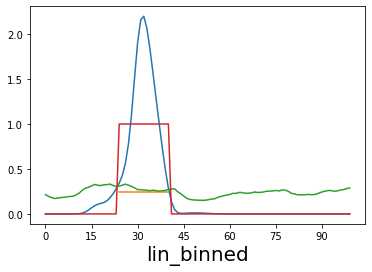

In [289]:
%matplotlib inline
uid=3
tt = (0,0)
fig,ax=plt.subplots()
fr_map_d[tt].loc[uid].plot(ax=ax)
bounds=all_fields_d[tt].loc[uid]

for f,bb in bounds.groupby(level=0):
    yy = sig_thresh_map_d[tt].loc[uid].mean()
    ax.plot((bb.loc[f,'start'],bb.loc[f,'end']),(yy,yy))
sig_thresh_map_d[tt].loc[uid].plot(ax=ax)

issig = fr_map_d[tt].loc[uid]>sig_thresh_map_d[tt].loc[uid]
ax.plot(issig)
ax.xaxis.set_major_locator(MaxNLocator(nbins=10))

# detection by trial

In [335]:
from mode_cluster import Kde_Peak_Cluster
reload(pf)

<module 'place_field_analysis' from '/mnt/home/szheng/projects/util_code/place_field_analysis.py'>

In [336]:
%%time
all_fields_bounds,sig_thesh_map_trial=pf.detect_significant_segments(fr_map_null[0,0],fr_map_trial_df)
allposbins = fr_map_trial_df.index.get_level_values(1).unique()
all_fields_bounds = pf.cluster_field_all_neurons(all_fields_bounds,cluster_key='com',model=Kde_Peak_Cluster,model_kws={'bw_method':0.1,'allposbins':allposbins,'peak_dist_thresh':7})





CPU times: user 47.5 s, sys: 139 ms, total: 47.6 s
Wall time: 47.6 s


In [60]:
# reload(pf)
# fields_bounds_one_neuron = all_fields_bounds.loc[283]
# pf.check_presence_one_neuron(fields_bounds_one_neuron)

field_index_cl
0    0.333333
1    0.333333
2    0.285714
dtype: float64

In [276]:
%%time
reload(pf)
trial_inds = fr_map_trial_df.columns
all_fields_bounds_merged_pivot_interp, all_fields_bounds_merged_interp, all_fields_presence = pf.interploate_field_across_trials_all_neuron(all_fields_bounds,trial_inds,combine_key='field_index_cl')





CPU times: user 14.6 s, sys: 3.34 ms, total: 14.6 s
Wall time: 14.6 s


In [296]:
local_presence_test_from_sig=all_fields_presence.astype(int).rolling(5,axis=1).apply(lambda x:x.mean()>=0.6)

In [297]:
ma = local_presence_test_from_sig.any(axis=1)

In [298]:
all_fields_bounds_merged_interp_filtered = all_fields_bounds_merged_interp.groupby(level=1).apply(lambda x:x.loc[ma.values]).reset_index(level=0,drop=True)



In [299]:
%%time
# field_params_trial = pf.get_peak_com_fr_from_all_fields_bounds(fr_map_trial_df,all_fields_bounds_merged_interp)
field_params_trial = pf.get_peak_com_fr_from_all_fields_bounds(fr_map_trial_df,all_fields_bounds_merged_interp_filtered)



/mnt/home/szheng/projects/nmf_analysis/nmf_analysis.py:365: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(inds * mat,axis=axis) / np.sum(mat,axis=axis)


CPU times: user 48.6 s, sys: 22 ms, total: 48.6 s
Wall time: 48.6 s


### combine

In [361]:
fr_map_trial_d_test = {k:val[range(4)] for k,val in fr_map_trial_d.items()}
cell_cols_test = cell_cols[:4]
fr_map_null_test = {k:val.loc[(slice(None),cell_cols_test),:] for k,val in fr_map_null.items()}

In [362]:
%%time
reload(pf)

field_params_trial_d, field_params_trial_filtered_d = pf.field_detection_by_trial(fr_map_trial_d_test,fr_map_null_test,cell_cols_test)


/mnt/home/szheng/projects/nmf_analysis/nmf_analysis.py:365: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(inds * mat,axis=axis) / np.sum(mat,axis=axis)


> /mnt/home/szheng/projects/util_code/place_field_analysis.py(596)field_detection_by_trial()
    594         pdb.set_trace()
    595 
--> 596         field_params_trial_filtered = field_params_trial.groupby(level=0).apply(lambda x:x.loc[ma.values].reset_index(level=0,drop=True))
    597         field_params_trial_filtered_d[key] = field_params_trial_filtered
    598 

ipdb> n
> /mnt/home/szheng/projects/util_code/place_field_analysis.py(597)field_detection_by_trial()
    595 
    596         field_params_trial_filtered = field_params_trial.groupby(level=0).apply(lambda x:x.loc[ma.values].reset_index(level=0,drop=True))
--> 597         field_params_trial_filtered_d[key] = field_params_trial_filtered
    598 
    599     return field_params_trial_d, field_params_trial_filtered_d

ipdb> c


/mnt/home/szheng/projects/nmf_analysis/nmf_analysis.py:365: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(inds * mat,axis=axis) / np.sum(mat,axis=axis)


> /mnt/home/szheng/projects/util_code/place_field_analysis.py(594)field_detection_by_trial()
    592         ma = local_presence_test(all_fields_presence,win=presence_test_win,ratio_min=presence_test_ratio)
    593         import pdb
--> 594         pdb.set_trace()
    595 
    596         field_params_trial_filtered = field_params_trial.groupby(level=0).apply(lambda x:x.loc[ma.values].reset_index(level=0,drop=True))

ipdb> c
CPU times: user 2.23 s, sys: 16.1 ms, total: 2.24 s
Wall time: 9.01 s


In [315]:
common_uid,diff_uid=misc.get_intersect_difference(field_params_trial.loc['com'].index.get_level_values(0).unique(),field_params_trial_avgmap_d[0,0].loc['fr'].index.get_level_values(0).unique())



In [320]:
field_params_trial_filtered.loc['peak_fr'].loc[diff_uid.iloc[4]].T.plot()

KeyError: 131.0

In [205]:
field_params_trial_avgmap.loc['fr_peak']

0          1          2          3          4          5   \
3   0   2.726724   6.556670   2.604235   0.000000   1.067943   0.000000   
27  0  25.437013  19.713628  34.266906  29.787902  33.812169  23.649173   
29  0   5.256609  10.298292  11.171087   8.307609  13.197394  15.507586   
    1  25.426426  22.606144  34.580452  33.254925  16.763604  20.502070   
    2   6.629354  31.612912  20.228251  11.154519  13.967411  15.050314   
...          ...        ...        ...        ...        ...        ...   
475 0  37.472192  25.361630  19.235385  20.526271  13.883253  17.306002   
476 0  29.368854   8.543309   3.676960   4.871101   2.135885  11.815026   
    1   0.024186   0.007054   0.017186   0.053034   0.335495   6.161253   
479 2   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
480 0  18.767170  27.384159  12.242159  19.964046  10.361135  23.883521   

              6          7          8          9   ...         23         24  \
3   0   0.000000   0.000000   0.000000   2.211117  ...   2.548487   2.443907   
27  0  41.734470  22.899713  26.879068  23.878131  ...  27.896680  43.962461   
29  0   9.340326  11.472431   9.062839   7.811972  ...   3.993601   0.602581   
    1  16.867060  24.613671  22.536541  25.753082  ...  30.332421  31.248178   
    2  12.125987   4.568459  14.604429  24.003156  ...  23.653827  19.017011   
...          ...        ...        ...        ...  ...        ...        ...   
475 0  19.004512   8.583724   8.193117   8.844469  ...   9.923012   2.466301   
476 0  10.437151   2.861241   3.072419   4.422235  ...   0.000000   0.000000   
    1   4.247951   0.259009   1.121073   5.413356  ...   0.000000   0.000000   
479 2   0.077865   0.000000   0.000000   0.000000  ...   0.000000   0.000000   
480 0   9.688319   6.794238   8.882412  12.252770  ...  16.660269  21.692968   

              25         26         27         28         29         30  \
3   0   3.274828   4.392889   3.833263   4.230902   4.049848   4.542321   
27  0  40.770307  38.378457  24.404045  29.738153  39.647722  25.301658   
29  0   6.309116   3.955652   3.052935   1.225830   0.758783   3.924130   
    1  29.927831  22.852687  33.338906  22.258196  30.373815  22.062408   
    2  14.740367  25.264925  17.599709  12.418266  14.687499  13.127737   
...          ...        ...        ...        ...        ...        ...   
475 0   7.797082   0.734838   0.934008   6.488496   7.657178   0.447768   
476 0   0.000000   0.000000   0.000000   0.000000   0.288711   0.000000   
    1   0.000000   0.071028   0.000000   0.000000   3.131800   0.000000   
479 2   0.000000   0.000000   0.000000   0.000000   4.111513   0.000000   
480 0  24.655881   8.764081  22.105571   8.621629  28.326568  21.137356   

              31         32  
3   0   3.385491   4.288309  
27  0  32.204385  31.734361  
29  0   0.424868   0.289393  
    1  28.034777  24.007206  
    2   7.586079  11.700405  
...          ...        ...  
475 0   1.503523   4.288309  
476 0   0.000000   0.000000  
    1   0.000000   0.000000  
479 2   0.000000  13.906161  
480 0  22.912878  20.047248  

[426 rows x 33 columns]

In [369]:
reload(pf)
pf.field_detection_both_avg_trial_wrapper(data_dir_full, dosave=True,force_reload=True,nbins = 100, 
                                        save_fn = 'place_field_avg_and_trial.p', 
                                        shuffle_fn='fr_map_null_trialtype.p',
                                        smth_in_bin=2.5, speed_thresh=1.
                                        )

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/fr_map_null_trialtype.p exists; loading---
cant format into a dataframe
cant format into a dataframe


/mnt/home/szheng/projects/nmf_analysis/nmf_analysis.py:365: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(inds * mat,axis=axis) / np.sum(mat,axis=axis)
/mnt/home/szheng/projects/nmf_analysis/nmf_analysis.py:365: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(inds * mat,axis=axis) / np.sum(mat,axis=axis)


saved at /mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/place_field_avg_and_trial.p


{(0,
  0.0): {'avg': {'params':                       0          1          2          3          4   \
   fr_mean 3   0   0.361854   1.660383   0.895757   0.000000   0.469929   
           27  0  16.708397  13.880437  23.144317  20.443347  22.024970   
           29  0   5.053373   5.417188   8.613645   7.675101   8.061945   
               1   9.346967   7.827861  16.289806  15.501734   6.856234   
               2   3.571403  17.352147  13.070307   7.509725   9.770912   
   ...                  ...        ...        ...        ...        ...   
   std     475 0   3.352010   2.988304   3.180797   2.980975   2.887596   
           476 0   2.200738   2.582691   2.525749   2.953935   2.652221   
               1   0.505189   0.344183   0.504879   0.579429   0.612717   
           479 2        NaN        NaN        NaN        NaN        NaN   
           480 0   3.167756   2.964996   3.480045   4.968335   3.709781   
   
                         5          6          7          8        

In [370]:
place_field_res=pf.field_detection_both_avg_trial_wrapper(data_dir_full, dosave=True,force_reload=False,nbins = 100, 
                                        save_fn = 'place_field_avg_and_trial.p', 
                                        shuffle_fn='fr_map_null_trialtype.p',
                                        smth_in_bin=2.5, speed_thresh=1.
                                        )

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/fr_map_null_trialtype.p exists; loading---
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/place_field_avg_and_trial.p exists; loading---


In [376]:
place_field_res[0,0]['avg']['params'].loc['fr_mean']

0          1          2          3          4          5   \
3   0   0.361854   1.660383   0.895757   0.000000   0.469929   0.000000   
27  0  16.708397  13.880437  23.144317  20.443347  22.024970  18.268363   
29  0   5.053373   5.417188   8.613645   7.675101   8.061945  14.067009   
    1   9.346967   7.827861  16.289806  15.501734   6.856234  12.040284   
    2   3.571403  17.352147  13.070307   7.509725   9.770912   6.556867   
...          ...        ...        ...        ...        ...        ...   
475 0  16.879054   9.340056   7.413745   7.560535   5.560227   6.468711   
476 0  11.266619   3.438997   1.612194   2.439140   1.141107   4.862664   
    1   0.003886   0.001022   0.002774   0.008994   0.057715   1.434997   
479 2   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
480 0   7.449776  10.446899   4.861817   8.256094   5.029402   9.404648   

              6          7          8          9   ...         23         24  \
3   0   0.000000   0.000000   0.000000   1.108933  ...   1.073200   1.116166   
27  0  24.778261  18.739717  14.663668  17.990234  ...  18.693228  24.730498   
29  0   7.950708   9.952814   7.850572   6.425151  ...   3.633616   0.091035   
    1  10.954014  11.643840  12.378693  13.069377  ...  17.828346  17.131333   
    2   6.550920   2.358153   5.706456  13.031921  ...  14.516956  12.498906   
...          ...        ...        ...        ...  ...        ...        ...   
475 0   6.196176   3.182649   3.593982   3.864743  ...   3.618452   0.924868   
476 0   3.363857   1.451238   1.714851   2.786387  ...   0.000000   0.000000   
    1   0.967460   0.045324   0.224307   4.136744  ...   0.000000   0.000000   
479 2   0.021653   0.000000   0.000000   0.000000  ...   0.000000   0.000000   
480 0   4.599918   3.774511   4.076486   8.046457  ...   7.941302  13.154010   

              25         26         27         28         29         30  \
3   0   1.424779   2.067007   1.727293   2.000177   1.997481   1.732614   
27  0  22.783916  27.507305  18.133893  21.390303  31.198415  19.328513   
29  0   5.054084   1.887250   2.549660   1.046473   0.525276   3.601365   
    1  19.303846  16.753613  16.884102  11.851607  15.579527  11.482377   
    2   8.034880  15.768769  11.469448   5.636619   6.409734   7.880987   
...          ...        ...        ...        ...        ...        ...   
475 0   2.890744   0.290307   0.343530   2.724236   2.062579   0.195726   
476 0   0.000000   0.000000   0.000000   0.000000   0.027696   0.000000   
    1   0.000000   0.020126   0.000000   0.000000   2.108780   0.000000   
479 2   0.000000   0.000000   0.000000   0.000000   3.562061   0.000000   
480 0  10.187630   4.884558   9.211893   3.877615  12.720201   8.925622   

              31         32  
3   0   1.364050   2.298617  
27  0  22.861668  20.969547  
29  0   0.080467   0.237707  
    1  12.537012  14.444362  
    2   4.618390   4.640929  
...          ...        ...  
475 0   0.651267   1.960399  
476 0   0.000000   0.000000  
    1   0.000000   0.000000  
479 2   0.000000  12.112211  
480 0  12.970490  10.225549  

[426 rows x 33 columns]

In [379]:
place_field_res[0,0]['trial'].loc['fr_mean']

0          1          2          3          4   \
      field_index_cl                                                          
1.0   0                     0.0        0.0        0.0        0.0        0.0   
      1                     0.0        0.0   0.712154   0.746947        0.0   
3.0   0                2.877257   3.523843   1.480452        0.0   0.792496   
27.0  0                16.90325  13.985368  23.596351  22.205938  24.215107   
      1               15.524918  10.346596  17.890603   21.95321  20.696121   
...                         ...        ...        ...        ...        ...   
479.0 2                1.712544        0.0   0.005425        0.0   1.763594   
      3                0.689526        0.0   1.152259        0.0        0.0   
      4                     0.0        0.0   0.001126        0.0        0.0   
480.0 0                0.085035   0.092917        0.0        0.0        0.0   
      1                9.466926   15.68169   6.391476   7.749943   6.489439   

                             5          6          7         8          9   \
      field_index_cl                                                         
1.0   0                     0.0        0.0        0.0       0.0        0.0   
      1                     0.0   0.448146        0.0       0.0   0.246957   
3.0   0                     0.0        0.0        0.0       0.0   1.468549   
27.0  0               18.374635  29.303404  19.096409   23.6677  21.144438   
      1               15.846239  20.629108  20.983865  8.732434  18.950011   
...                         ...        ...        ...       ...        ...   
479.0 2                0.019566   4.028269        0.0       0.0   0.077226   
      3                     0.0    1.29817        0.0       0.0        0.0   
      4                     0.0   0.114586        0.0       0.0        0.0   
480.0 0                2.712841        0.0        0.0       0.0   0.531111   
      1               13.379184   6.516173   5.429701  5.937056   8.824189   

                      ...         23         24         25         26  \
      field_index_cl  ...                                               
1.0   0               ...        0.0        0.0        0.0        0.0   
      1               ...        0.0        0.0    0.28082    0.24712   
3.0   0               ...   1.481991    1.46424   1.962058   2.355158   
27.0  0               ...  23.805635  28.250967  26.150792  24.120941   
      1               ...   9.836824  22.979402  11.099323  26.982009   
...                   ...        ...        ...        ...        ...   
479.0 2               ...        0.0    0.25124   1.389174        0.0   
      3               ...        0.0        0.0        0.0        0.0   
      4               ...        0.0        0.0        0.0        0.0   
480.0 0               ...        0.0        0.0        0.0        0.0   
      1               ...  10.951693  13.997943  11.334211   6.341034   

                             27         28         29         30         31  \
      field_index_cl                                                          
1.0   0                     0.0        0.0        0.0        0.0        0.0   
      1                     0.0   0.044191        0.0    0.34993        0.0   
3.0   0                2.271366   2.650873   2.240767   2.219345   1.868561   
27.0  0                20.96887  22.249353  32.385438  19.983623   23.20988   
      1               11.095134  21.251442  21.142099  19.679443  20.595904   
...                         ...        ...        ...        ...        ...   
479.0 2                     0.0        0.0        0.0        0.0        0.0   
      3                     0.0        0.0   0.134812        0.0        0.0   
      4                     0.0        0.0   2.898967        0.0        0.0   
480.0 0                     0.0        0.0        0.0        0.0        0.0   
      1               11.881084   6.152887  16.041193  12.557332  12.048828   

        

In [380]:
place_field_res[0,0]['trial_filter'].loc['fr_mean']

0          1          2          3          4   \
      field_index_cl                                                          
3.0   0                2.877257   3.523843   1.480452        0.0   0.792496   
27.0  0                16.90325  13.985368  23.596351  22.205938  24.215107   
      3               21.574272  21.770784   20.86045  21.026823  22.188152   
      4               24.812102  27.976769  22.403973  24.173521  23.235987   
29.0  0                5.127133   5.810619   8.532628   7.329907   9.457675   
...                         ...        ...        ...        ...        ...   
476.0 0               12.640459   4.321239   1.657652   2.753825   0.823559   
      1               14.645991   4.360346   2.315357   2.440772   1.584991   
478.0 1                     0.0   3.520606   0.960445        0.0   1.085072   
479.0 2                1.712544        0.0   0.005425        0.0   1.763594   
480.0 1                9.466926   15.68169   6.391476   7.749943   6.489439   

                             5          6          7          8          9   \
      field_index_cl                                                          
3.0   0                     0.0        0.0        0.0        0.0   1.468549   
27.0  0               18.374635  29.303404  19.096409    23.6677  21.144438   
      3               22.347425  22.172338  26.481037  19.843761  17.230244   
      4               26.344703  21.205789  23.079543  23.865525  27.418143   
29.0  0               11.831089   7.747524   9.389151   7.292901   6.500804   
...                         ...        ...        ...        ...        ...   
476.0 0                2.613057   1.364586   1.128968   1.225767   2.208052   
      1                6.248878    5.05841   2.137272   2.337533   3.283797   
478.0 1                     0.0        0.0        0.0        0.0        0.0   
479.0 2                0.019566   4.028269        0.0        0.0   0.077226   
480.0 1               13.379184   6.516173   5.429701   5.937056   8.824189   

                      ...         23         24         25         26  \
      field_index_cl  ...                                               
3.0   0               ...   1.481991    1.46424   1.962058   2.355158   
27.0  0               ...  23.805635  28.250967  26.150792  24.120941   
      3               ...  24.387645  19.379538  22.336519  21.850833   
      4               ...  24.790096  28.574008  24.568612  26.091652   
29.0  0               ...   3.799885   0.011401   5.718256   1.557402   
...                   ...        ...        ...        ...        ...   
476.0 0               ...        0.0        0.0        0.0        0.0   
      1               ...        0.0        0.0        0.0        0.0   
478.0 1               ...        0.0   0.453246   0.104153        0.0   
479.0 2               ...        0.0    0.25124   1.389174        0.0   
480.0 1               ...  10.951693  13.997943  11.334211   6.341034   

                             27         28         29         30         31  \
      field_index_cl                                                          
3.0   0                2.271366   2.650873   2.240767   2.219345   1.868561   
27.0  0                20.96887  22.249353  32.385438  19.983623   23.20988   
      3                25.28756  20.341809  22.630022  19.503111  24.911291   
      4               28.795513  23.619307  20.252213   25.12989  21.242033   
29.0  0                2.552714   1.131185    0.56112   3.751338   0.023737   
...                         ...        ...        ...        ...        ...   
476.0 0                     0.0        0.0   0.000271        0.0        0.0   
      1                     0.0        0.0   0.112844        0.0        0.0   
478.0 1                1.285858   0.300581        0.0        0.0   0.933359   
479.0 2                     0.0        0.0        0.0        0.0        0.0   
480.0 1               11.881084   6.152887  16.041193  12.557332  12.048828

# checking one example

In [222]:
%matplotlib inline
import plot_raster as pr
reload(pr)

<module 'plot_raster' from '/mnt/home/szheng/projects/util_code/plot_raster.py'>

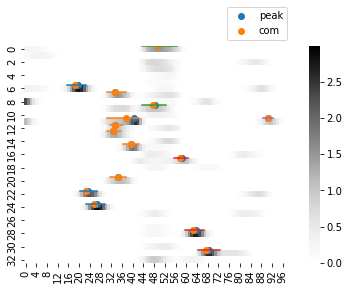

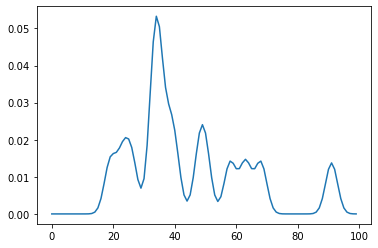

In [321]:
uid = 131#268#100#295#3 # 
# uid = all_fields_bounds.index.get_level_values(0).unique()[21]
fields_bounds_one_neuron = copy.copy(all_fields_bounds.loc[uid])

cluster_key='com'
location_to_be_clustered=fields_bounds_one_neuron[cluster_key].values

kde_kws = {'bw_method':0.1,'allposbins':allposbins,'peak_dist_thresh':7}
kde_cl = pf.Kde_Peak_Cluster(**kde_kws)
cl,pdf = kde_cl.fit_predict_with_pdf(location_to_be_clustered)
fields_bounds_one_neuron['field_index_cl']=cl

fig,ax = pr.plot_field_boundaries(fields_bounds_one_neuron,cl_key='field_index_cl')

sns.heatmap(fr_map_trial_df.loc[uid].T,cmap='Greys')
ax.scatter(fields_bounds_one_neuron['peak'],fields_bounds_one_neuron.index,label='peak')
ax.scatter(fields_bounds_one_neuron['com'],fields_bounds_one_neuron.index,label='com')
plt.legend(bbox_to_anchor=[1,1.2])

plt.figure()
plt.plot(pdf)